In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../")) 

from utils.data_utils import DeepFashionSubsetDataset
from models.dual_branch_CNN import DualBranchCNNClassifier
from models.small_single_branch_CNN import SmallSingleBranchCNN
from models.deep_single_branch_CNN import DeepSingleBranchCNN
from torchvision import transforms
from torch.utils.data import DataLoader 


In [2]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

In [3]:
train_csv = "../data/subset/train/classification_metadata.csv"
train_img_folder = "../data/subset/train/images"

val_csv = "../data/subset/val/classification_metadata.csv"
val_img_folder = "../data/subset/val/images"

train_dataset = DeepFashionSubsetDataset(
    csv_file=train_csv,
    images_folder=train_img_folder,
    transform=train_transform,
    use_bbox=True
)

val_dataset = DeepFashionSubsetDataset(
    csv_file=val_csv,
    images_folder=val_img_folder,
    transform=val_transform,
    use_bbox=True
)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
print(f"Number of training samples:   {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")


Number of training samples:   6461
Number of validation samples: 1300


In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Metal (MPS) device:", device)
else:
    device = torch.device("cpu")
    print("Using CPU:", device)

model = SmallSingleBranchCNN(num_classes=13)
model = model.to(device)

Using Apple Metal (MPS) device: mps


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
NUM_EPOCHS = 25

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    scheduler.step()
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

train_history = []
val_history = []

csv_filename = "training_results.csv"
with open(csv_filename, "w") as f:
    f.write("Epoch,Train Loss,Train Acc,Val Loss,Val Acc,Time (s)\n")  

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    train_history.append((train_loss, train_acc))
    val_history.append((val_loss, val_acc))
    
    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% "
          f"Time: {epoch_time:.2f}s")
    
    with open(csv_filename, "a") as f:
        f.write(f"{epoch+1},{train_loss:.4f},{train_acc:.2f},{val_loss:.4f},{val_acc:.2f},{epoch_time:.2f}\n")
    
# save model
torch.save(model.state_dict(), "small_single_branch.pth")
print(f"Training results saved in {csv_filename}")


Epoch [1/25] Train Loss: 2.5039 | Train Acc: 12.58% Val Loss: 2.5101 | Val Acc: 13.38% Time: 125.92s
Epoch [2/25] Train Loss: 2.4243 | Train Acc: 17.03% Val Loss: 2.4962 | Val Acc: 13.38% Time: 118.94s
Epoch [3/25] Train Loss: 2.3705 | Train Acc: 19.24% Val Loss: 2.4001 | Val Acc: 19.85% Time: 134.32s
Epoch [4/25] Train Loss: 2.3157 | Train Acc: 21.67% Val Loss: 2.4002 | Val Acc: 19.23% Time: 151.27s
Epoch [5/25] Train Loss: 2.2620 | Train Acc: 22.95% Val Loss: 2.2983 | Val Acc: 21.38% Time: 135.52s
Epoch [6/25] Train Loss: 2.2091 | Train Acc: 24.32% Val Loss: 2.3941 | Val Acc: 18.92% Time: 143.60s
Epoch [7/25] Train Loss: 2.1629 | Train Acc: 25.88% Val Loss: 2.2849 | Val Acc: 23.08% Time: 137.38s
Epoch [8/25] Train Loss: 2.1072 | Train Acc: 28.49% Val Loss: 2.2368 | Val Acc: 25.08% Time: 131.75s
Epoch [9/25] Train Loss: 2.0657 | Train Acc: 29.47% Val Loss: 2.1481 | Val Acc: 29.38% Time: 133.34s
Epoch [10/25] Train Loss: 2.0205 | Train Acc: 31.09% Val Loss: 2.1915 | Val Acc: 26.23% Tim

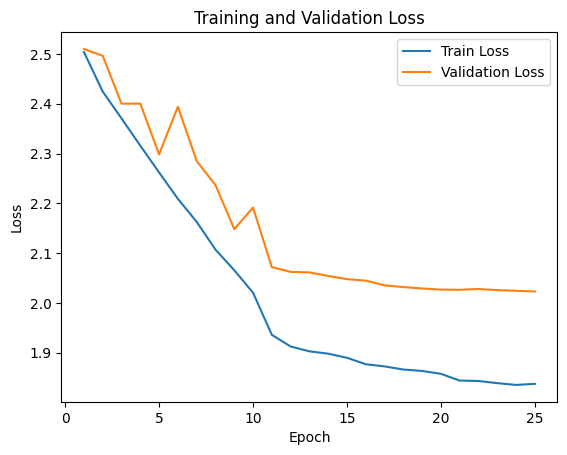

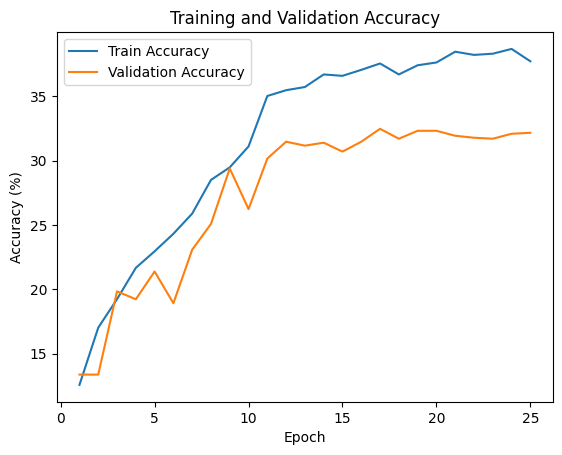

In [6]:
# Plot accuracy and loss for training and val set
epochs = range(1, NUM_EPOCHS + 1)
train_losses, train_accs = zip(*train_history)
val_losses, val_accs = zip(*val_history)

# Plot loss
plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("training_validation_loss.png", dpi=300, bbox_inches="tight")
plt.show()

# Plot accuracy
plt.figure()
plt.plot(epochs, train_accs, label="Train Accuracy")
plt.plot(epochs, val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig("training_validation_accuracy.png", dpi=300, bbox_inches="tight")
plt.show()

